In [1]:
import os
import sys
module_path=os.path.abspath("../FTrojan")
sys.path.append(module_path)

import numpy as np
import torch
from data import get_data, poison
from torch.utils.data import DataLoader, TensorDataset
import torch.optim
from data import impose

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import torch.nn as nn

2023-09-26 07:04:00.993537: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
torch.cuda.is_available()

True

In [3]:
class cifar_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 32, (3, 3), padding=1),        # 32 x 32 x 32
            nn.ELU(),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 32, (3, 3), padding=1),       # 32 x 32 x 32
            nn.ELU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(2, 2)),           # 32 x 16 x 16
            nn.Dropout2d(0.2),

            nn.Conv2d(32, 64, (3, 3), padding=1),       # 64 x 16 x 16
            nn.ELU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, (3, 3), padding=1),       # 64 x 16 x 16
            nn.ELU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(2, 2)),           # 64 x 8 x 8
            nn.Dropout2d(0.3),

            nn.Conv2d(64, 128, (3, 3), padding=1),      # 128 x 8 x 8
            nn.ELU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, (3, 3), padding=1),     # 128 x 8 x 8
            nn.ELU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=(2, 2)),            # 128 x 4 x 4
            nn.Dropout2d(0.4),
            nn.Flatten(),
            nn.Linear(2048, 10)
        )

    def forward(self, x_train):
        return self.main(x_train)



In [4]:
def train_cifar10():
    param = {
        "dataset": "CIFAR10",             # GTSRB, cifar10, MNIST, PubFig, ImageNet16
        "target_label": 8,              # target label
        "poisoning_rate": 0.02,         # ratio of poisoned samples
        "label_dim": 10,
        "channel_list": [1, 2],               # [0,1,2] means YUV channels, [1,2] means UV channels
        "magnitude": 20,
        "YUV": True,
        "clean_label": False,
        "window_size": 32,
        "pos_list": [(31, 31), (15, 15)],
    }

    x_train, y_train, x_test, y_test = get_data(param)
    #print(x_train)
    x_train = poison(x_train, y_train, param)
    x_test_pos = impose(x_test.copy(), y_test.copy(), param)
    y_test_pos = np.array([param["target_label"]] * x_test_pos.shape[0], dtype=np.long)
    x_train, x_test, x_test_pos = np.transpose(x_train, (0, 3, 1, 2)), np.transpose(x_test, (0, 3, 1, 2)), np.transpose(x_test_pos, (0, 3, 1, 2))

    x_train, y_train = torch.tensor(x_train, dtype=torch.float), torch.tensor(y_train, dtype=torch.long).view((-1, ))
    x_test, y_test = torch.tensor(x_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.long).view((-1, ))
    x_test_pos, y_test_pos = torch.tensor(x_test_pos, dtype=torch.float), torch.tensor(y_test_pos, dtype=torch.long).view((-1, ))


    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=64, shuffle=True)
    test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=64, shuffle=False)
    test_pos_loader = DataLoader(TensorDataset(x_test_pos, y_test_pos), batch_size=64, shuffle=False)


    model = cifar_model().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

    max_accuracy = 0.0
    filepath = "model/cifar10.pth"
    for epoch in range(30):
        model.train()
        total_loss = torch.tensor(0.0).to(device)
        correct = torch.tensor(0).to(device)
        total = torch.tensor(0).to(device)
        batch_idx = torch.tensor(0).to(device)
        for (batch_x, batch_y) in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            total_loss += loss
            batch_idx += 1
        print("Training: Epoch: {}, Loss: {:.4}, Accuracy: {:.4}".format(epoch, total_loss/batch_idx, 100 * correct/total))


        total_loss = 0.0
        correct = 0.0
        total = 0.0
        batch_idx = 0
        model.eval()
        with torch.no_grad():
            for (batch_x, batch_y) in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)

                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
                total_loss += loss
                batch_idx += 1
            print("Benign Accuracy Evaluation - Epoch: {}, Loss: {:.4}, Accuracy: {:.4}".format(epoch, total_loss / batch_idx, 100 * correct / total))
        if 100 * correct / total > max_accuracy:
            print("model improve from {:.2} to {:.2}, saved".format(max_accuracy, 100 * correct/total))
            max_accuracy = 100 * correct / total
            torch.save(model, filepath)

        total_loss = 0.0
        correct = 0.0
        total = 0.0
        batch_idx = 0
        with torch.no_grad():
            for (batch_x, batch_y) in test_pos_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)

                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
                total_loss += loss
                batch_idx += 1
            print("Attack Success Rate Evaluation - Epoch: {}, Loss: {:.4}, Accuracy: {:.4}\n".format(epoch, total_loss / batch_idx, 100 * correct / total))



In [ ]:
train_cifar10()

In [5]:
from matplotlib import pyplot as plt

def tester():
    
    param = {
        "dataset": "CIFAR10",             # GTSRB, cifar10, MNIST, PubFig, ImageNet16
        "target_label": 8,              # target label
        "poisoning_rate": 0.02,         # ratio of poisoned samples
        "label_dim": 10,
        "channel_list": [1, 2],               # [0,1,2] means YUV channels, [1,2] means UV channels
        "magnitude": 20,
        "YUV": True,
        "clean_label": False,
        "window_size": 32,
        "pos_list": [(31, 31), (15, 15)],
    }
    x_train, y_train, x_test, y_test = get_data(param)
    #print(x_train)
    x_test_pos = impose(x_test.copy(), y_test.copy(), param)
    y_test_pos = np.array([param["target_label"]] * x_test_pos.shape[0], dtype=np.long)

    sample_img=(x_test[12]*255).astype(np.uint8)
    sample_img_pos=(x_test_pos[12]*255).astype(np.uint8)
    sample_img_diff=sample_img-sample_img_pos

    plt.imshow(sample_img)
    plt.show()
    print("Inditify label:")
    print(y_test[12])
    plt.imshow(sample_img_pos)
    plt.show()
    print("Inditify label:")
    print(y_test_pos[12])
    plt.imshow(sample_img_diff)
    plt.show()

    x_test, x_test_pos =np.transpose(x_test, (0, 3, 1, 2)), np.transpose(x_test_pos, (0, 3, 1, 2))

    x_test, y_test = torch.tensor(x_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.long).view((-1, ))
    x_test_pos, y_test_pos = torch.tensor(x_test_pos, dtype=torch.float), torch.tensor(y_test_pos, dtype=torch.long).view((-1, ))

    test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=64, shuffle=False)
    test_pos_loader = DataLoader(TensorDataset(x_test_pos, y_test_pos), batch_size=64, shuffle=False)

    model = torch.load("model/cifar10.pth")
    criterion = nn.CrossEntropyLoss()

    total_loss = 0.0
    correct = 0.0
    total = 0.0
    batch_idx = 0
    model.eval()
    with torch.no_grad():
        for (batch_x, batch_y) in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            total_loss += loss
            batch_idx += 1
        print("Benign Accuracy Evaluation - Epoch: {}, Loss: {:.4}, Accuracy: {:.4}".format(0, total_loss / batch_idx, 100 * correct / total))

    total_loss = 0.0
    correct = 0.0
    total = 0.0
    batch_idx = 0
    with torch.no_grad():
        for (batch_x, batch_y) in test_pos_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            total_loss += loss
            batch_idx += 1
        print("Attack Success Rate Evaluation - Epoch: {}, Loss: {:.4}, Accuracy: {:.4}\n".format(0, total_loss / batch_idx, 100 * correct / total))

/tmp/ipykernel_19756/1192617156.py:20: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_test_pos = np.array([param["target_label"]] * x_test_pos.shape[0], dtype=np.long)


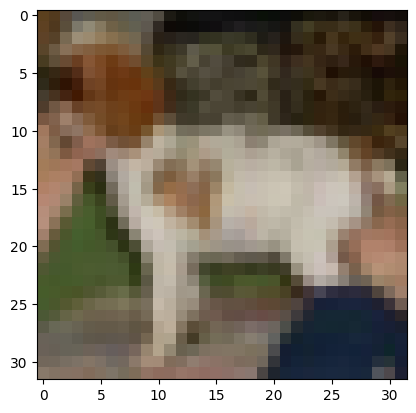

Inditify label:
[5]


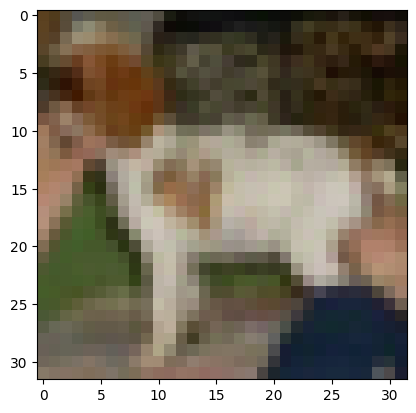

Inditify label:
8


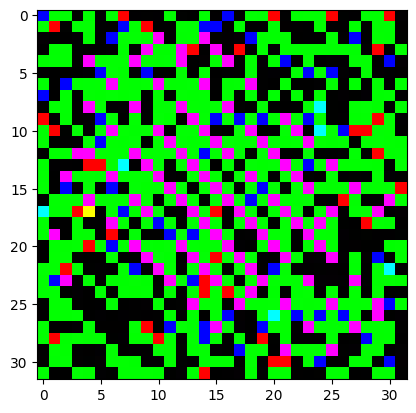

FileNotFoundError: [Errno 2] No such file or directory: 'model/cifar10.pth'

In [6]:
tester()